Данные о продажах в онлайн-ритейлере


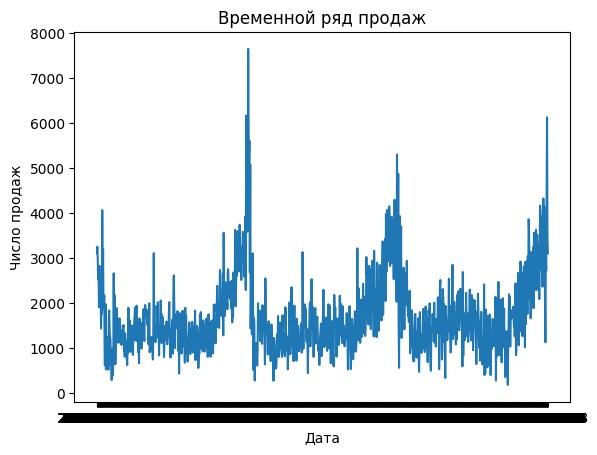

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("online_retail.csv")

plt.plot(data["date"], data["total sales"])
plt.xlabel("Дата")
plt.ylabel("Число продаж")
plt.title("Временной ряд продаж")
plt.show()

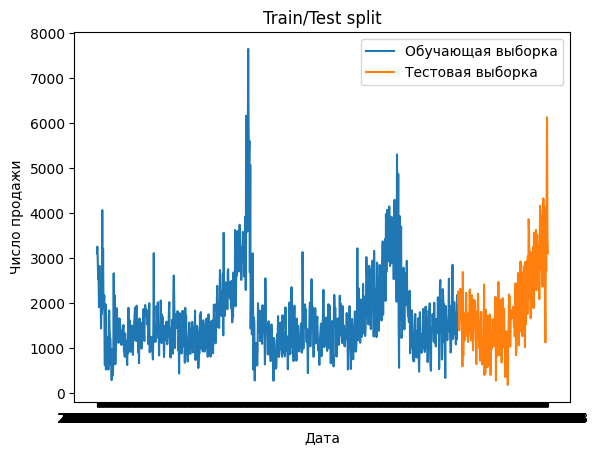

In [3]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

plt.plot(train_data["date"], train_data["total sales"], label="Обучающая выборка")
plt.plot(test_data["date"], test_data["total sales"], label="Тестовая выборка")
plt.xlabel("Дата")
plt.ylabel("Число продажи")
plt.title("Train/Test split")
plt.legend()
plt.show()

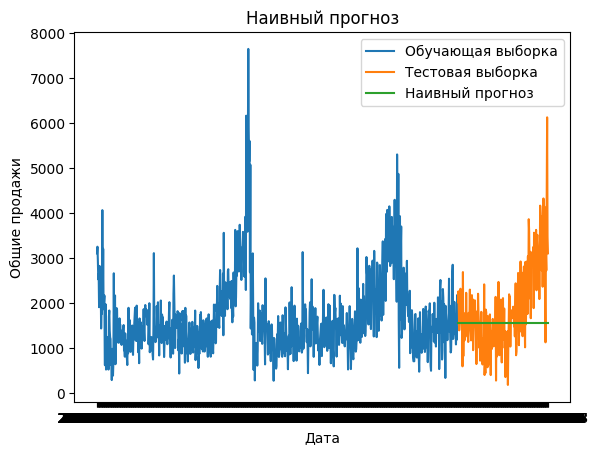

In [4]:
import numpy as np

naive_forecast = np.repeat(train_data["total sales"].values[-1], len(test_data))

plt.plot(train_data["date"], train_data["total sales"], label="Обучающая выборка")
plt.plot(test_data["date"], test_data["total sales"], label="Тестовая выборка")
plt.plot(test_data["date"], naive_forecast, label="Наивный прогноз")
plt.xlabel("Дата")
plt.ylabel("Общие продажи")
plt.title("Наивный прогноз")
plt.legend()
plt.show()

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test_data["total sales"], naive_forecast)
mae = mean_absolute_error(test_data["total sales"], naive_forecast)

print("MSE наивного прогноза:", mse)
print("MAE наивного прогноза:", mae)

MSE наивного прогноза: 971724.8110583076
MAE наивного прогноза: 706.8169459426873


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
from sklearn.model_selection import train_test_split

df = pd.read_csv('online_retail.csv', parse_dates=['date'], index_col='date')
data = df['total sales']

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

result = adfuller(train_data)
print("ADF статистика:", result[0])
print("p-value:", result[1])


ADF статистика: -3.0495151022439986
p-value: 0.030521975094373203


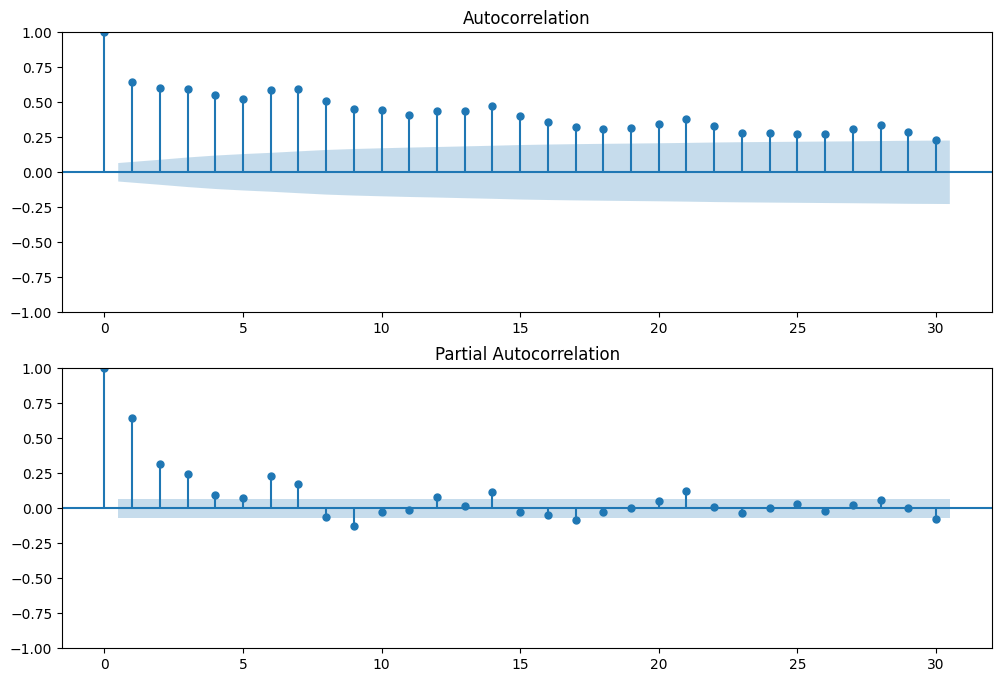

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train_data, ax=ax1, lags=30)
plot_pacf(train_data, ax=ax2, lags=30)
plt.show()

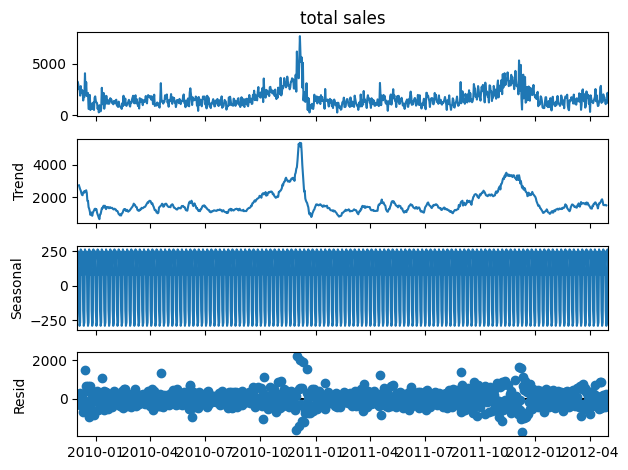

In [8]:
decomposition = seasonal_decompose(train_data, model='additive', period=7)
decomposition.plot()
plt.show()

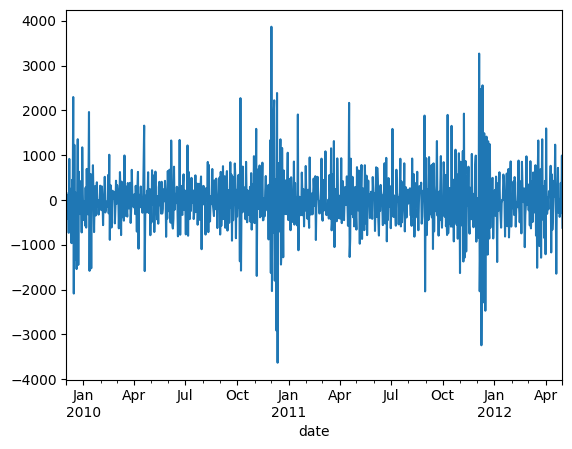

In [9]:
diff_train_data = train_data.diff().dropna()
diff_train_data.plot()
plt.show()

ADF статистика: -9.19970908147118
p-value: 2.017486419005399e-15


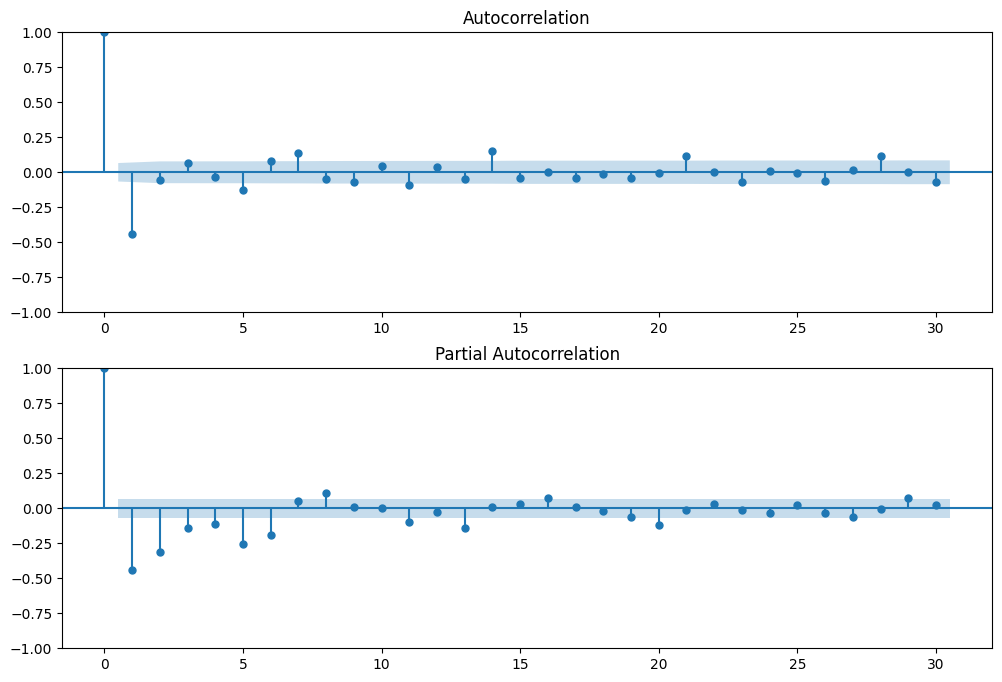

In [10]:
result = adfuller(diff_train_data)
print("ADF статистика:", result[0])
print("p-value:", result[1])
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(diff_train_data, ax=ax1, lags=30)
plot_pacf(diff_train_data, ax=ax2, lags=30)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


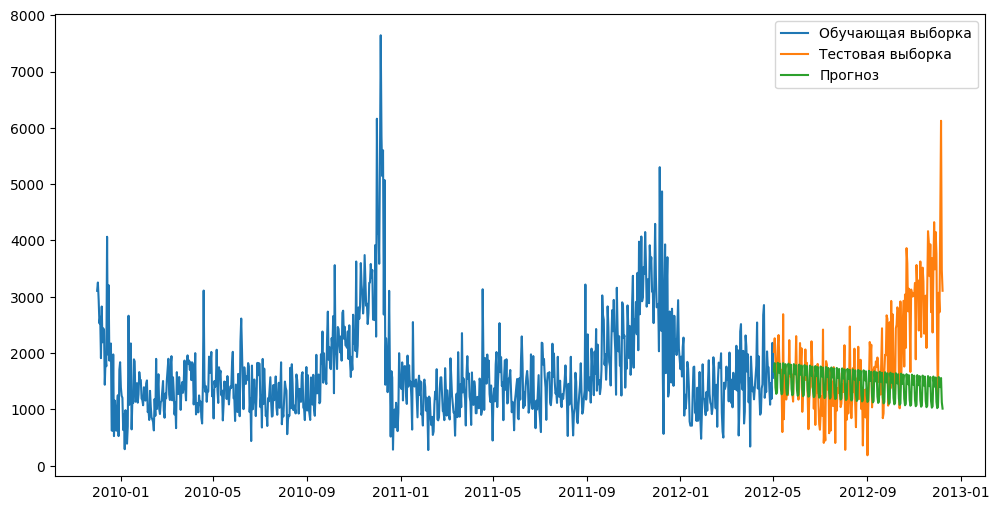

In [11]:
model = sarimax.SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
fitted_model = model.fit()

forecast = fitted_model.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Обучающая выборка')
plt.plot(test_data.index, test_data, label='Тестовая выборка')
plt.plot(forecast_mean.index, forecast_mean, label='Прогноз')
plt.legend()
plt.show()

In [12]:
mse = ((forecast_mean - test_data) ** 2).mean()
print("MSE:", mse)

baseline = test_data.shift(1).dropna()
mse_baseline = ((baseline - test_data) ** 2).mean()
print("MSE базового решения:", mse_baseline)

MSE: 1088838.4485868292
MSE базового решения: 637657.9566836528


In [13]:
!pip install lime
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=38a0eaf168a9b42405cfeee778967f2099026947faea9564993e893eb9d506bb
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 8.7 MB/s eta 0:00:00


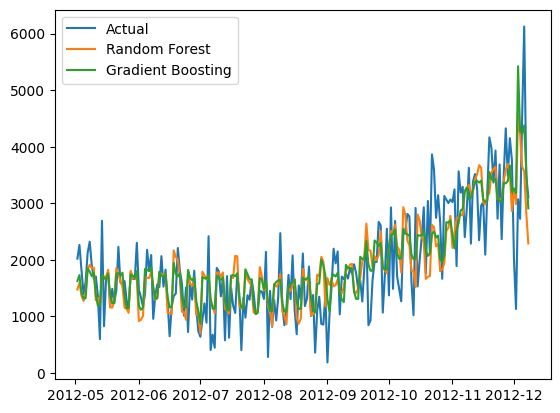

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lime
import lime.lime_tabular
import shap

data = pd.read_csv("online_retail.csv")

data['date'] = pd.to_datetime(data['date'])
data['day_of_week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['day_of_month'] = data['date'].dt.day
data['day_of_year'] = data['date'].dt.dayofyear

train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

rf = RandomForestRegressor()
rf.fit(train_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']], train_data['total sales'])

gb = GradientBoostingRegressor()
gb.fit(train_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']], train_data['total sales'])

plt.plot(test_data['date'], test_data['total sales'], label='Actual')
plt.plot(test_data['date'], rf.predict(test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']]), label='Random Forest')
plt.plot(test_data['date'], gb.predict(test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']]), label='Gradient Boosting')
plt.legend()
plt.show()

In [15]:
rf_mse = np.mean((rf.predict(test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']]) - test_data['total sales']) ** 2)
gb_mse = np.mean((gb.predict(test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']]) - test_data['total sales']) ** 2)
print(f"Random Forest MSE: {rf_mse}")
print(f"Gradient Boosting MSE: {gb_mse}")

Random Forest MSE: 370172.3134592238
Gradient Boosting MSE: 319056.0632909516


In [16]:
perm = lime.lime_tabular.LimeTabularExplainer(train_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']].values, mode='regression')
perm_importance = perm.explain_instance(test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']].iloc[0].values, rf.predict).as_map()[1]
print("Permutation Importance:")
for feature, importance in zip(['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year'], perm_importance):
    print(f"{feature}: {importance}")


Permutation Importance:
day_of_week: (4, -339.25938401685005)
month: (0, 171.4030248730873)
year: (2, 86.85683638634075)
day_of_month: (3, 28.93678118469531)
day_of_year: (1, -2.4920129601329926)


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


In [17]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(train_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']].values, mode='regression')
lime_explanation = lime_explainer.explain_instance(test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']].iloc[0].values, rf.predict)
print("LIME explanation:")
print(lime_explanation.as_list())

LIME explanation:
[('74.00 < 4 <= 160.00', -341.85779258551344), ('1.00 < 0 <= 3.00', 197.62299409081677), ('2 > 2011.00', 94.15168700791311), ('3 <= 8.00', 51.529589436586306), ('3.00 < 1 <= 6.00', -27.666578042366414)]


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


SHAP local interpretation:


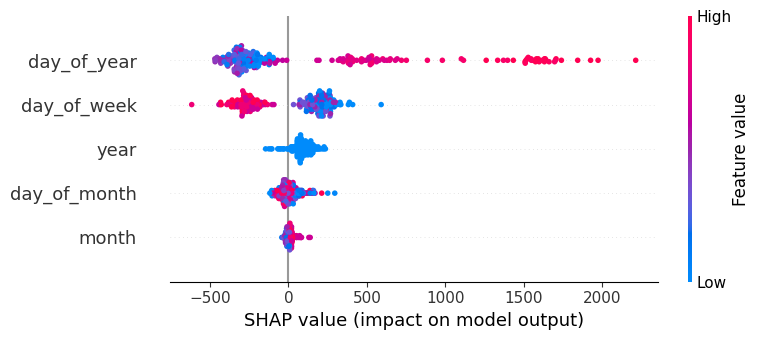

In [18]:
shap_explainer_local = shap.Explainer(rf)
shap_values_local = shap_explainer_local(test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']])
print("SHAP local interpretation:")
shap.summary_plot(shap_values_local, test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']])

SHAP global interpretation:


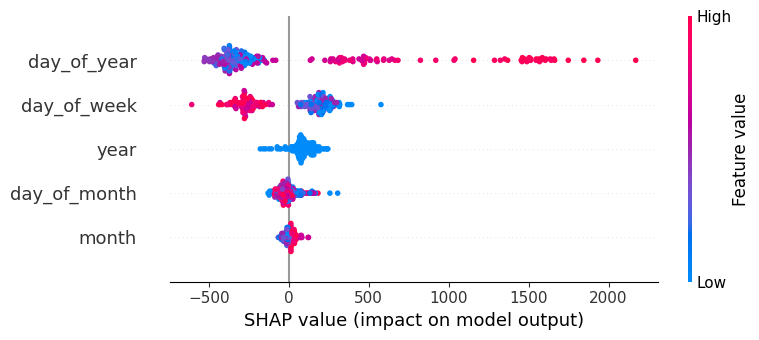

In [19]:
shap_explainer_global = shap.Explainer(rf, train_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']])
shap_values_global = shap_explainer_global(test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']])
print("SHAP global interpretation:")
shap.summary_plot(shap_values_global, test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']])

Вывод:Модель случайного леса и градиентного бустинга обучены на данных по продажам. Результаты визуализированы, произведены замеры их качества. Модель случайного леса интерпретируется с помощью permutation importance, LIME и SHAP. SHAP и применяется для локальной и глобальной интерпретации модели. Интерпретация позволяет понять, какие признаки оказывают наибольшее влияние на результаты модели.